<a href="https://colab.research.google.com/github/IIF0403/Project/blob/master/test_example_PyTorch_classification_Earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pathlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from fastai import *
import pandas as pd

In [ ]:

!curl -O http://www.timeseriesclassification.com/Downloads/Earthquakes.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  763k  100  763k    0     0   294k      0  0:00:02  0:00:02 --:--:--  294k


In [ ]:
!unzip Earthquakes.zip

Archive:  Earthquakes.zip
  inflating: Earthquakes.txt         
  inflating: Earthquakes_TEST.arff   
  inflating: Earthquakes_TEST.txt    
  inflating: Earthquakes_TRAIN.arff  
  inflating: Earthquakes_TRAIN.txt   
  inflating: Earthquakes_TEST.ts     
  inflating: Earthquakes_TRAIN.ts    


In [ ]:
bs=64
DATASET = "Earthquakes"
classes = 2

path = pathlib.Path('')

In [ ]:
def one_hot_encode(input, labels):
    m = input.shape[0]
    output = np.zeros((m, labels), dtype=int)
    row_index = np.arange(m)
    output[row_index, input] = 1
    return output

def split_xy(data, classes):
    X = data[:, 1:]
    y = data[:, 0].astype(int)
    # hot encode
    #y = one_hot_encode(y, classes)
    return X, y

def create_dataset(X, y, device):
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    y_tensor = torch.tensor(y, dtype=torch.long, device=device)
    return TensorDataset(X_tensor, y_tensor)

def load_data(path, classes):
    data = np.loadtxt(path)
    return split_xy(data, classes)

In [ ]:
# load training dataset Earthquake
X_train, y_train = load_data(path/'Earthquakes_TRAIN.txt', classes) 
# Shape: (322, 512) og (322, )

# load testing dataset
X_test, y_test = load_data(path/'Earthquakes_TEST.txt', classes)
# Shape: (139, 512) og (139, )


print('X_train %s   y_train %s' % (X_train.shape, y_train.shape))
print('X_test  %s   y_test  %s' % (X_test.shape, y_test.shape))

#As the classes are imbalanced, get count for each class, to use later
class_0_count = (y_train==0).sum()
class_1_count = (y_train==1).sum()

print("class_0_count: ",class_0_count)
print("class_1_count: ",class_1_count)


X_train (322, 512)   y_train (322,)
X_test  (139, 512)   y_test  (139,)
class_0_count:  264
class_1_count:  58


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Load numpy training and test sets into PyTorch Dataset object
train_ds = create_dataset(X_train, y_train, device)
test_ds  = create_dataset(X_test, y_test, device)

print(len(train_ds))
print(len(test_ds))

#Pass the dataset object into a DataLoader
train_dl = DataLoader(train_ds, batch_size = bs, shuffle=False)
test_dl = DataLoader(test_ds, batch_size = bs, shuffle=False)

322
139


In [ ]:
#Just checking the sizes
train_iter = iter(train_dl)
train_x, train_y = train_iter.next()

test_iter = iter(test_dl)
test_x, test_y = test_iter.next()

print("Batch_size: ", bs)
print("x_train shape on PyTorch: ", train_x.size())
print("y_train shape on PyTorch: ", train_y.size())
print("x_test shape on PyTorch: ", test_x.size())
print("y_test shape on PyTorch: ", test_y.size())

Batch_size:  64
x_train shape on PyTorch:  torch.Size([64, 512])
y_train shape on PyTorch:  torch.Size([64])
x_test shape on PyTorch:  torch.Size([64, 512])
y_test shape on PyTorch:  torch.Size([64])


In [ ]:
class_sample_count = [class_0_count, class_1_count]
weights = 1 / torch.Tensor(class_sample_count)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, bs)


**Classifier**

FCN block: The core component of a FCN is a convolutional block that contains


*   Convolutional layer with filter size of 128 or 256
*   Batch normalizatopn layer with momentum 0.99 and epsilon 0.001
* a ReLU activation at the en dof the block
* an optional squeeze excite block


In [ ]:
class BlockFCNConv(nn.Module):
  def __init__(self, in_channel=1, out_channel=128, kernel_size=8, momentum=0.99, epsilon=0.001, squeeze=False):
    super().__init__()
    self.conv = nn.Conv1d(in_channel, out_channel, kernel_size=kernel_size)
    self.batch_norm = nn.BatchNorm1d(num_features=out_channel, eps=epsilon, momentum=momentum)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # input (batch_size, num_variables, time_steps), e.g. (128, 1, 512)
    x = self.conv(x)
    # input (batch_size, out_channel, L_out)
    x = self.batch_norm(x)
    # same shape as input
    y = self.relu(x)
    return y

The fully convolutional block contains three of these convolutional blocks, used as a feature extractor. Then it uses a global average pooling layer to generate channel_wise statistics

In [ ]:
class FCN(nn.Module):
  def __init__(self, time_steps, channels=[1, 128, 256, 128], kernels=[8, 5, 3], mom=0.99, eps=0.001):
    super().__init__()
    self.conv1 = BlockFCNConv(channels[0], channels[1], kernels[0], momentum=mom, epsilon=eps, squeeze=True)
    self.conv2 = BlockFCNConv(channels[1], channels[2], kernels[1], momentum=mom, epsilon=eps, squeeze=True)
    self.conv3 = BlockFCNConv(channels[2], channels[3], kernels[2], momentum=mom, epsilon=eps)
    output_size = time_steps - sum(kernels) + len(kernels)
    self.global_pooling = nn.AvgPool1d(kernel_size=output_size)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    # apply Global Average Pooling 1D
    y = self.global_pooling(x)
    return y


If we want a LSTM-FCN:

In [ ]:
#LSTM block: A shuffle layer + LSTM lauer + dropout layer
class BlockLSTM(nn.Module):
  def __init__(self, time_steps, num_layers, lstm_hs, dropout=0.8, attention=False):
    super().__init__()
    self.lstm = nn.LSTM(input_size=time_steps, hidden_size=lstm_hs, num_layers=num_layers)
    self.dropout = nn.Dropout(p=dropout)
  def forward(self, x):
    # input is of the form (batch_size, num_layers, time_steps), e.g. (128, 1, 512)
    x = torch.transpose(x, 0, 1)
    # lstm layer is of the form (num_layers, batch_size, time_steps)
    x, (h_n, c_n) = self.lstm(x)
    # dropout layer input shape (Sequence Length, Batch Size, Hidden Size * Num Directions)
    y = self.dropout(x)
    # output shape is same as Dropout intput
    return y

#LSTM-FCN
class LSTMFCN(nn.Module):
  def __init__(self, time_steps, num_variables=1, lstm_hs=256, channels=[1, 128, 256, 128]):
    super().__init__()
    self.lstm_block = BlockLSTM(time_steps, 1, lstm_hs)
    self.fcn_block = FCN(time_steps)
    self.dense = nn.Linear(channels[-1] + lstm_hs, num_variables)
    self.softmax = nn.LogSoftmax(dim=1) #nn.Softmax(dim=1)
  def forward(self, x):
    # input is (batch_size, time_steps), it has to be (batch_size, 1, time_steps)
    x = x.unsqueeze(1)
    # pass input through LSTM block
    x1 = self.lstm_block(x)
    x1 = torch.squeeze(x1)
    # pass input through FCN block
    x2 = self.fcn_block(x)
    x2 = torch.squeeze(x2)
    # concatenate blocks output
    x = torch.cat([x1, x2], 1)
    # pass through Linear layer
    x = self.dense(x)
    #x = torch.squeeze(x)
    # pass through Softmax activation
    y = self.softmax(x)
    return y


**Training**

In [ ]:
time_steps = X_train.shape[1]
num_variables = classes

#FCN-model
#model = FCN(time_steps)#.cuda()

#LSTM-FCN-model
model = LSTMFCN(time_steps, num_variables)#.cuda()
#print(model)

In [ ]:
#model summary
for m in model.children():
  print(m.training)
  for j in m.children():
    print(j.training, j)

True
True LSTM(512, 256)
True Dropout(p=0.8, inplace=False)
True
True BlockFCNConv(
  (conv): Conv1d(1, 128, kernel_size=(8,), stride=(1,))
  (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True BlockFCNConv(
  (conv): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (batch_norm): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True BlockFCNConv(
  (conv): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (relu): ReLU()
)
True AvgPool1d(kernel_size=(499,), stride=(499,), padding=(0,))
True
True


In [ ]:
#look at weights in each layer
[p.shape for p in model.parameters()]

[torch.Size([1024, 512]),
 torch.Size([1024, 256]),
 torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([128, 1, 8]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([256, 128, 5]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([128, 256, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([2, 384]),
 torch.Size([2])]

Defining a learner class to automate the learning process

In [ ]:
class SimpleLearner():
  def __init__(self, data, model, loss_func, wd = 1e-5):
    self.data, self.model, self.loss_func = data, model, loss_func
    self.wd = wd

  def update_manualgrad(self, x,y,lr):
    y_hat = self.model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = self.loss_func(y_hat, y) + w2 * self.wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()


  def update(self, x,y,lr):
    opt = torch.optim.Adam(self.model.parameters(), lr)
    y_hat = self.model(x)
    loss = self.loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

  def fit(self, epochs=1, lr=1e-3):
    #Train the model
    losses = []
    for i in tqdm(range(epochs)):
        for x,y in self.data[0]:
            current_loss = self.update(x, y , lr)
            losses.append(current_loss)
    return losses


  def evaluate(self, X):
    #Evaluate the given data loader on the model and return predictions
    result = None
    for x, y in X:
        y_hat = self.model(x).detach().numpy()
        result = y_hat if result is None else np.concatenate((result, y_hat), axis=0)
        predicted = torch.max(output.data,1)
    return result
  

loss function

In [53]:
loss_func = nn.NLLLoss().cuda()
#loss_func = nn.CrossEntropyLoss()  
#acc_func = accracy_thresh

lr = 2e-2
learner = SimpleLearner([train_dl, test_dl], model, loss_func)

100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


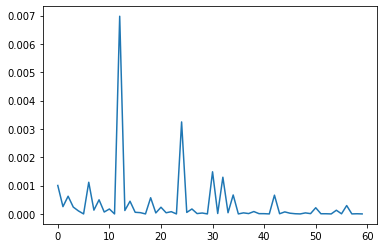

In [55]:
losses = learner.fit(10)
plt.plot(losses)

In [54]:
#y_pred = learner.evaluate(X=test_dl)
from sklearn.metrics import accuracy_score
correct = 0
total=0
accuracy_list =[]
with torch.no_grad():
  for x, y in test_dl:
    output=model(x)
    predicted= torch.max(output.data,1)[1]
    accuracy_list.append(accuracy_score(y, predicted))

accuracy = np.mean(accuracy_list)
print(accuracy)




0.696496212121212
